In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import validation_curve
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.cluster import KMeans
import statsmodels.api as sm
import math
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p

In [16]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

In [17]:
df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df = df[df.schedule_season > 1978]

df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

df['over_under_result'] = np.where(df['over_under_result']=='under', 0, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='over', 1, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='push', 2, df.over_under_result)

df = df.fillna(value = 0)

df.index = range(0, len(df))

In [18]:
reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 19) & (df.schedule_season>2001)]

In [19]:
cluster_df = week5_df[['score_home','home_losses', 'spread_favorite','away_exp_win_pct','away_pt_diff_pg','weather_wind_mph','away_win_pct_last_4','h_ppg','home_exp_win_pct','home_pt_diff_pg','home_favorite','home_win_pct_last_4', 'over_under_line']]
cluster_df['home_variance'] = (cluster_df.score_home - cluster_df.h_ppg)

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
X = cluster_df[['score_home','home_variance']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
cluster_df['cluster'] = y_kmeans
print(len(y_kmeans[(y_kmeans == 0)]))
print(len(y_kmeans[(y_kmeans == 1)]))
print(len(y_kmeans[(y_kmeans == 2)]))
print(len(y_kmeans[(y_kmeans == 3)]))
print(len(y_kmeans[(y_kmeans == 4)]))
print(kmeans.cluster_centers_)

1480
1012
618
0
0
[[24.53581081  2.75578378]
 [12.37252964 -9.40529644]
 [37.75889968 15.42852751]]


/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


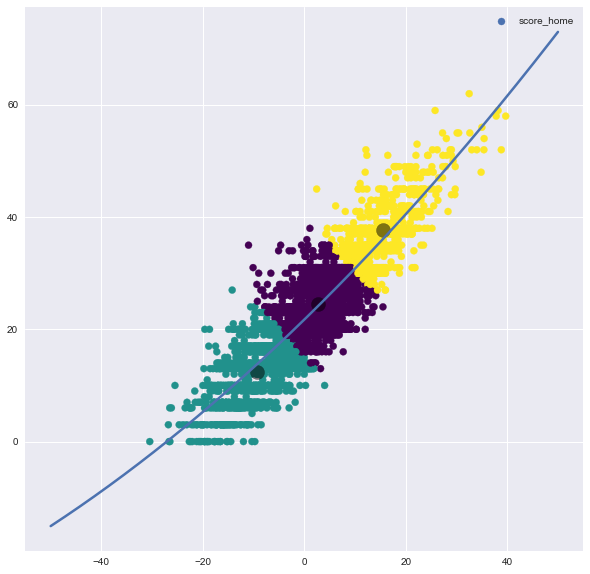

In [37]:
plt.figure(figsize = (10,10))
plt.scatter(cluster_df.home_variance, cluster_df.score_home, c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)
poly_model = make_pipeline(PolynomialFeatures(),
                               LinearRegression())
poly_model.fit(X.home_variance[:, np.newaxis], X.score_home)
xfit = np.linspace(-50,50, 10000)
yfit = poly_model.predict(xfit[:, np.newaxis])
plt.plot(xfit, yfit,linewidth=2.5)
plt.legend(loc = 'best');